# Emerging Topics final code - Pandemics

This code was created from Martha and Sean's emerging topic code and was used to create the hottest/coldest topics static graphics for the full, pandemics, and coronavirus corpora.

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 50)

import numpy as np
import pickle
import matplotlib.pyplot as plt
import gensim
import time
import re

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression as lm
from scipy import stats

import matplotlib.collections as mcol
from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple
from matplotlib.lines import Line2D

import seaborn as sns

### Data Ingestion

In [2]:
# full corpus
#df = pd.read_pickle("../../data/final/final_dataset_7-20.pkl")

# pandemic corpus
df = pd.read_pickle("../../../../data/prd/Tech-Report/case_studies/pandemic_corpus.pkl")
df.reset_index(inplace=True)

# coronavirus corpus -- NEED TO CREATE
#df = pd.read_pickle("/home/kjl5t/dspg20RnD/data/final/dashboard_data/corona_corpus.pkl")
#df.reset_index(inplace=True)

In [3]:
df.head()

,level_0,index,original index,PROJECT_ID,ABSTRACT,FY,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,PROJECT_END_DATE,CONTACT_PI_PROJECT_LEADER,OTHER_PIS,CONGRESSIONAL_DISTRICT,DUNS_NUMBER,ORGANIZATION_NAME,ORGANIZATION_CITY,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY.y,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS,ORG_COUNT,PI_COUNT,final_tokens
0,338,338,380,90045,Study of Emerging Networks in Outbreak Respons...,2008,Arts; Communicable Diseases; Communication; Co...,STUDY OF EMERGING NETWORKS IN OUTBREAK RESPONSE,NSF,NSF,NaN,0826995,9/15/2008,8/31/2012,"ANSELL, CHRISTOPHER","KELLER, ANN; REINGOLD, ARTHUR",09,124726725,UNIVERSITY OF CALIFORNIA BERKELEY,BERKELEY,CA,94704-5940,UNITED STATES,NaN,NaN,47.075,2008,726706.0,NaN,1,1,"[study, emerge, network, outbreak, responsepri..."
1,464,464,524,90243,One of the products of human development and p...,2008,Affect; Agriculture; anthropogenesis; Award; b...,HSD: COLLABORATIVE RESEARCH: HUMAN-RELATED FAC...,NSF,NSF,NaN,0826779,10/1/2008,3/31/2012,"DASZAK, PETER","KILPATRICK, A MARM",08,077090066,ECOHEALTH ALLIANCE INC,NEW YORK,NY,10001-2320,UNITED STATES,NaN,NaN,47.075,2008,468673.0,NaN,2,2,"[product, human, development, population, grow..."
2,761,761,859,90573,Intellectual merit:The proposed project seeks ...,2008,base; Basic Science; Biological; Biology; Bird...,COMBINING ECOLOGICAL AND MOLECULAR MODELS TO U...,NSF,NSF,NaN,0827416,9/1/2008,8/31/2011,"KOELLE, KATHARINA",NaN,04,044387793,DUKE UNIVERSITY,DURHAM,NC,27705-4010,UNITED STATES,NaN,NaN,47.074,2008,610071.0,NaN,1,1,"[intellectual_merit, propose, project, seek, d..."
3,1253,1253,1400,91397,West Nile virus re-emerges annually in urban s...,2008,Birds; Chicago; Culicidae; Disease; Environmen...,WEST NILE VIRUS: ECO-EPIDEMIOLOGY OF DISEASE E...,NSF,NSF,NaN,0840403,9/1/2008,8/31/2012,"GOLDBERG, TONY L.","BRAWN, JEFFREY; RUIZ, MARILYN; KITRON, URIEL; ...",02,003255648,UNIVERSITY OF WISCONSIN SYSTEM,MADISON,WI,53715-1218,UNITED STATES,NaN,NaN,47.074,2008,1964529.0,NaN,1,1,"[west_nile, virus, re_emerge, annually, urban,..."
4,3300,3300,3661,93669,About five percent of the world's population d...,2008,Affect; Disabled Persons; Disease; Emerging Co...,RESEARCH STARTER: POPULATION DYNAMICS AND EVOL...,NSF,NSF,NaN,0804039,8/1/2008,7/31/2010,"DENNEHY, JOHN J",NaN,09,064932676,RESEARCH FOUNDATION OF THE CITY UNIVERSITY OF ...,FLUSHING,NY,11367-1575,UNITED STATES,NaN,NaN,47.074,2008,67848.0,NaN,1,1,"[percent, world, population, die, major, influ..."


In [4]:
# input needed for LDA, NMF (all from Scikit-Learn) is one string per document (not a list of strings)

text = []
docs = df["final_tokens"]

for abstract in docs:
    text.append(" ".join(abstract))

### Functions needed for all models

In [5]:
# function slightly modified from https://nlpforhackers.io/topic-modeling/

def print_topics(topic_term_mat, vectorizer, top_n=10):
    for idx, topic in enumerate(topic_term_mat):  # loop through each row of H.  idx = row index.  topic = actual row
        print("\nTopic %d:" % (idx))
        #print([(vectorizer.get_feature_names()[i], topic[i])  # printing out words corresponding to indices found in next line
                        #for i in topic.argsort()[:-top_n - 1:-1]])  # finding indices of top words in topic
            
        print_list = [(vectorizer.get_feature_names()[i], topic[i])  
                        for i in topic.argsort()[:-top_n - 1:-1]]
        for item in print_list:
            print(item)
        

In [6]:
# Function to format topics as a "list of list of strings".
# Needed for topic coherence function in Gensim

# function modified from https://nlpforhackers.io/topic-modeling/

def str_topics(topic_term_mat, vectorizer, top_n=10):

    #input. top_n: how many words to list per topic.  If -1, then list all words.
       
    topic_words = []
    
    for idx, topic in enumerate(topic_term_mat):  # loop through each row of H.  idx = row index.  topic = actual row
            
        if top_n == -1:   
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[::-1]])
        else:
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[:-top_n - 1:-1]])
    
    str_wds = []
    
    for wds in topic_words:
        str_wds.append(", ".join(wds))    
    
    return str_wds 

## NMF
- Optimal Model: full dataset, 75 topics, random_state = 14
- Pandemic Model: pandemic dataset, 30, random_state = 1
- Coronavirus Model: coronavirus dataset, 30, random_state = 1

In [7]:
# use for full dataset
#tfidf_vectorizer = TfidfVectorizer(max_df=0.6, min_df=20, lowercase=False, max_features=int(len(docs)/2))
#tf_idf = tfidf_vectorizer.fit_transform(text)

stop_wds = ['research', 'study', 'project']

# use for pandemic or coronavirus dataset
tfidf_vectorizer = TfidfVectorizer(max_df=1.0, min_df=3, lowercase=False, stop_words=stop_wds)
tf_idf = tfidf_vectorizer.fit_transform(text)


In [8]:
# create model

num_topics = 30 

t1 = time.time()
nmf_model = NMF(n_components=num_topics, random_state = 1)
doc_topic = nmf_model.fit_transform(tf_idf)
t2 = time.time()
print(f"  Model time: {t2-t1}")

topic_term = nmf_model.components_

  Model time: 7.466167449951172


/apps/software/standard/compiler/gcc/9.2.0/jupyter_conda/2020.11-py3.8/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [9]:
print_topics(topic_term, tfidf_vectorizer, 10)


Topic 0:
('influenza', 4.780366126138502)
('vaccination', 0.45696442127207854)
('strain', 0.4366870879362975)
('child', 0.4099784277283389)
('virus', 0.3788252008124538)
('respiratory', 0.35825706543465824)
('year', 0.3540015997286329)
('age', 0.3223154056871477)
('infection', 0.3189847026903103)
('effectiveness', 0.314156054611063)

Topic 1:
('hiv', 2.515296209640142)
('aids', 0.3616600614300892)
('infect', 0.19641332542436854)
('env', 0.1610144620010576)
('prevention', 0.13855102202283415)
('antiretroviral', 0.13390796553184064)
('infection', 0.12844009825049965)
('woman', 0.12639331635544593)
('individual', 0.12077306602849737)
('transmission', 0.11788568419456656)

Topic 2:
('virus', 2.2118564173459445)
('human', 0.4408905676482216)
('cause', 0.22111288563117096)
('infect', 0.19830647260077594)
('vector', 0.17825649597001567)
('animal', 0.17620487062747195)
('infection', 0.17369296716519003)
('avian_influenza', 0.16357168221179338)
('isolate', 0.16065691013915884)
('species', 0.16

### Topic Trends

In [14]:
# Extract Year from PROJECT_START_DATE

#On our graphs, we want to be able to show year. Therefore, this getYear function gets the year from different date formats from Project Start Year/End Year

#START

def getYear(a):   
    a = str(a)
    if a.find("/"):
        splitdate = a.split("/")
        if len(splitdate) == 3:
            a = splitdate[2]
        else:
            a = splitdate[0]
    year = str(a)
    return year

df['START_YEAR'] = df['PROJECT_START_DATE'].apply(getYear)

In [15]:
sum(df['PROJECT_START_DATE'].isna())

0

In [16]:
df['START_YEAR'].value_counts(dropna=False)

2009    409
2010    385
2011    366
2008    323
2012    322
2016    255
2014    244
2015    243
2013    210
2018    201
2017    197
2019    175
2007    151
2006     73
2003     52
2005     41
2004     39
2001     23
1999     20
2002     17
2000     11
1997     10
1998      9
1993      8
1983      7
1990      6
1991      5
1987      5
1977      5
1994      5
1996      3
1989      3
1995      3
1976      3
1981      3
1992      3
1984      1
2020      1
1979      1
1980      1
Name: START_YEAR, dtype: int64

In [26]:
# quick look at abstracts with Topic 9

topic_9_df = pd.DataFrame(doc_topic, columns=["Topic"+" "+str(i) for i in range(num_topics)])
topic_9_df["START_YEAR"] = df["START_YEAR"].astype(int)

In [27]:
topic_9_df

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29,START_YEAR
0,0.000000,0.000000,0.003584,0.003692,0.006140,0.000000,0.000994,0.000719,0.010612,0.001915,0.003389,0.073446,0.000000,0.000000,0.010666,0.000000,0.000000,0.000000,0.001130,0.000000,0.000000,0.000000,0.000000,0.00000,0.008297,0.000000,0.000000,0.000041,0.000000,0.011779,2008
1,0.000000,0.000000,0.001239,0.000000,0.000000,0.005268,0.004141,0.000000,0.005710,0.000000,0.000000,0.092310,0.000000,0.000000,0.028525,0.000000,0.018171,0.000000,0.007547,0.019979,0.000000,0.000000,0.000905,0.00000,0.012592,0.000000,0.000000,0.007005,0.000000,0.000000,2008
2,0.019744,0.007443,0.000000,0.000975,0.000000,0.000000,0.000000,0.000000,0.000000,0.006397,0.000000,0.047016,0.041610,0.000000,0.022236,0.000000,0.001007,0.000000,0.000000,0.000022,0.000000,0.000000,0.022254,0.00000,0.006976,0.013733,0.007989,0.041418,0.000000,0.000000,2008
3,0.000000,0.000000,0.045170,0.000000,0.000000,0.000000,0.000000,0.000000,0.011018,0.000000,0.000000,0.038425,0.005765,0.000000,0.000000,0.000000,0.019057,0.000000,0.000000,0.000000,0.000000,0.003510,0.017647,0.00000,0.002166,0.000000,0.000000,0.001948,0.000000,0.005708,2008
4,0.008935,0.000000,0.057854,0.000000,0.000000,0.000000,0.000000,0.000000,0.004231,0.003504,0.000000,0.038822,0.015763,0.000000,0.021240,0.000000,0.001131,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.001476,0.000000,0.000000,0.002402,0.000000,0.001552,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3834,0.000000,0.004532,0.088879,0.000000,0.028562,0.000000,0.048099,0.015019,0.000000,0.000000,0.002375,0.000000,0.001368,0.000000,0.000000,0.006397,0.000000,0.003527,0.000000,0.000000,0.007323,0.009376,0.000000,0.00000,0.000000,0.000532,0.042062,0.000000,0.008747,0.005493,2017
3835,0.038697,0.000000,0.031014,0.013845,0.051847,0.000000,0.003090,0.000000,0.000000,0.000000,0.000000,0.003337,0.000000,0.000000,0.000971,0.000242,0.014329,0.000000,0.000000,0.003381,0.000623,0.002966,0.000000,0.00000,0.070511,0.000957,0.000000,0.000000,0.010335,0.000000,2017
3836,0.000000,0.000000,0.090739,0.001806,0.000000,0.001017,0.017820,0.000000,0.000000,0.000000,0.000000,0.010223,0.015495,0.000000,0.000000,0.000000,0.003043,0.000000,0.000000,0.000000,0.000000,0.000000,0.000115,0.00334,0.002549,0.000000,0.004535,0.022437,0.008839,0.000000,2012
3837,0.000000,0.000000,0.051031,0.012597,0.000000,0.000000,0.000822,0.000000,0.000000,0.000000,0.000000,0.020778,0.008402,0.001755,0.000000,0.001292,0.005902,0.000000,0.000000,0.000000,0.001438,0.002345,0.000000,0.00000,0.016554,0.000000,0.000000,0.000000,0.000000,0.001120,2012


In [28]:
topic_9_df = topic_9_df[topic_9_df["START_YEAR"] > 2009] 
topic_9_df = topic_9_df[topic_9_df["START_YEAR"] < 2020]

In [58]:
topic_9_df[topic_9_df["Topic 9"] > 0.2]

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29,START_YEAR
1075,0.009401,0.001070,0.010705,0.000000,0.047044,0.005727,0.006459,0.000000,0.006721,0.208819,0.001782,0.005781,0.008489,0.000000,0.012602,0.001466,0.000000,0.000000,0.000000,0.000000,0.002188,0.000000,0.000000,0.003532,0.000000,0.000000,0.000000,0.000000,0.000000,0.000043,2011
1173,0.000000,0.000000,0.015057,0.013799,0.000010,0.005644,0.000000,0.070844,0.000000,0.201999,0.000000,0.000000,0.000000,0.000000,0.001928,0.000225,0.000000,0.023117,0.000000,0.007683,0.000000,0.000000,0.000000,0.000000,0.002127,0.000000,0.030549,0.000000,0.000000,0.000000,2011
1507,0.009401,0.001070,0.010705,0.000000,0.047044,0.005727,0.006459,0.000000,0.006721,0.208819,0.001782,0.005781,0.008489,0.000000,0.012602,0.001466,0.000000,0.000000,0.000000,0.000000,0.002188,0.000000,0.000000,0.003532,0.000000,0.000000,0.000000,0.000000,0.000000,0.000043,2011
1512,0.000000,0.000000,0.015057,0.013799,0.000010,0.005644,0.000000,0.070844,0.000000,0.201999,0.000000,0.000000,0.000000,0.000000,0.001928,0.000225,0.000000,0.023117,0.000000,0.007683,0.000000,0.000000,0.000000,0.000000,0.002127,0.000000,0.030549,0.000000,0.000000,0.000000,2011
2158,0.019443,0.000000,0.000000,0.011711,0.000000,0.000000,0.000000,0.000000,0.000000,0.224982,0.000000,0.000000,0.054630,0.000000,0.006392,0.000000,0.014988,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010589,0.000000,0.001710,0.010184,0.000000,0.000000,2013
2518,0.000000,0.000000,0.000101,0.004479,0.064024,0.000000,0.003668,0.000000,0.000000,0.241688,0.000000,0.002583,0.013680,0.000000,0.000000,0.000000,0.001240,0.000000,0.000000,0.001829,0.000000,0.002404,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2015
2519,0.000000,0.000000,0.000000,0.005163,0.065347,0.000000,0.000000,0.000000,0.001033,0.227260,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006790,0.000000,0.003126,0.000000,0.000861,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2015
2587,0.000843,0.001953,0.000790,0.000000,0.027692,0.017378,0.008624,0.000000,0.000250,0.250034,0.000000,0.000000,0.000000,0.000000,0.000000,0.001978,0.000000,0.003234,0.006387,0.000000,0.003473,0.000000,0.000000,0.000832,0.000000,0.000000,0.017303,0.004856,0.013815,0.000000,2015
2687,0.000000,0.000000,0.000000,0.003921,0.058469,0.000000,0.000000,0.000000,0.001283,0.269968,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005852,0.000237,0.002584,0.000000,0.001251,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2016
2744,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.082393,0.000000,0.235082,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019208,0.000000,0.000000,0.009741,0.000000,2016


In [65]:
df["ABSTRACT"].iloc[2749]

'\ufeff   DESCRIPTION (provided by applicant): Influenza A virus (IAV) is an upper respiratory pathogen in humans that causes seasonal epidemics and sporadic pandemics[18-20]. Well known for its promiscuous host species tropism, IAV can infect waterfowl, domestic birds, swine, humans, and sea mammals[21]. IAV strains endemic to waterfowl and domestic animals are capable of spontaneously crossing the species barrier, leading to outbreaks in other host species and even pandemics in humans[22-25]. This adaptability is in part achieved through the inherent low fidelity of the encoded RNA dependent RNA polymerase; however, the host factors that contribute to efficient IAV transmission between species and/or maintain viral fitness upon infection of a new host remain unknown[26, 27]. We have recently identified ADAR1 as a host factor that is essential for optimal IAV replication and progeny fitness. We will further our understanding of the relationship between ADAR1 and IAV by (1) identifying

In [42]:
max(topic_9_df["Topic 9"])

0.2929449067980932

In [17]:
#Pulls sample data subsetted by year then takes mean theta for each abstract

topic_frame = pd.DataFrame(doc_topic, columns=["Topic"+" "+str(i) for i in range(num_topics)])
topic_frame["START_YEAR"] = df["START_YEAR"]


#### compute count of projects with weight > 0 for each topic

In [18]:
topic_proj_count = topic_frame.copy()

In [19]:
topic_proj_count.head()

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29,START_YEAR
0,0.000000,0.000000,0.003584,0.003692,0.00614,0.000000,0.000994,0.000719,0.010612,0.001915,0.003389,0.073446,0.000000,0.0,0.010666,0.0,0.000000,0.0,0.001130,0.000000,0.0,0.00000,0.000000,0.0,0.008297,0.000000,0.000000,0.000041,0.0,0.011779,2008
1,0.000000,0.000000,0.001239,0.000000,0.00000,0.005268,0.004141,0.000000,0.005710,0.000000,0.000000,0.092310,0.000000,0.0,0.028525,0.0,0.018171,0.0,0.007547,0.019979,0.0,0.00000,0.000905,0.0,0.012592,0.000000,0.000000,0.007005,0.0,0.000000,2008
2,0.019744,0.007443,0.000000,0.000975,0.00000,0.000000,0.000000,0.000000,0.000000,0.006397,0.000000,0.047016,0.041610,0.0,0.022236,0.0,0.001007,0.0,0.000000,0.000022,0.0,0.00000,0.022254,0.0,0.006976,0.013733,0.007989,0.041418,0.0,0.000000,2008
3,0.000000,0.000000,0.045170,0.000000,0.00000,0.000000,0.000000,0.000000,0.011018,0.000000,0.000000,0.038425,0.005765,0.0,0.000000,0.0,0.019057,0.0,0.000000,0.000000,0.0,0.00351,0.017647,0.0,0.002166,0.000000,0.000000,0.001948,0.0,0.005708,2008
4,0.008935,0.000000,0.057854,0.000000,0.00000,0.000000,0.000000,0.000000,0.004231,0.003504,0.000000,0.038822,0.015763,0.0,0.021240,0.0,0.001131,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.001476,0.000000,0.000000,0.002402,0.0,0.001552,2008


In [20]:
topic_count_bool = (topic_proj_count.iloc[:,0:num_topics] > 0)
topic_count_bool["START_YEAR"] = topic_proj_count["START_YEAR"]

In [21]:
topic_count_bool

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29,START_YEAR
0,False,False,True,True,True,False,True,True,True,True,True,True,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,True,False,True,2008
1,False,False,True,False,False,True,True,False,True,False,False,True,False,False,True,False,True,False,True,True,False,False,True,False,True,False,False,True,False,False,2008
2,True,True,False,True,False,False,False,False,False,True,False,True,True,False,True,False,True,False,False,True,False,False,True,False,True,True,True,True,False,False,2008
3,False,False,True,False,False,False,False,False,True,False,False,True,True,False,False,False,True,False,False,False,False,True,True,False,True,False,False,True,False,True,2008
4,True,False,True,False,False,False,False,False,True,True,False,True,True,False,True,False,True,False,False,False,False,False,False,False,True,False,False,True,False,True,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3834,False,True,True,False,True,False,True,True,False,False,True,False,True,False,False,True,False,True,False,False,True,True,False,False,False,True,True,False,True,True,2017
3835,True,False,True,True,True,False,True,False,False,False,False,True,False,False,True,True,True,False,False,True,True,True,False,False,True,True,False,False,True,False,2017
3836,False,False,True,True,False,True,True,False,False,False,False,True,True,False,False,False,True,False,False,False,False,False,True,True,True,False,True,True,True,False,2012
3837,False,False,True,True,False,False,True,False,False,False,False,True,True,True,False,True,True,False,False,False,True,True,False,False,True,False,False,False,False,True,2012


In [22]:
topic_count_bool.sum(axis=1).median()

12.0

In [19]:
# same calculation but grouped by year

topic_counts = topic_count_bool.groupby("START_YEAR").sum().reset_index()
topic_counts = topic_counts.sort_values(by = "START_YEAR")  # pretty sure this is unnecessary
topic_counts["START_YEAR"] = topic_counts["START_YEAR"].astype(int)


In [20]:
#topic_counts

In [21]:
topic_counts_filt = topic_counts[topic_counts["START_YEAR"] > 2009] 
topic_counts_filt = topic_counts_filt[topic_counts_filt["START_YEAR"] < 2020]

In [22]:
topic_counts_filt

,START_YEAR,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29
29,2010,174,159,239,220,217,161,174,139,154,139,173,202,202,88,160,141,161,151,143,143,124,128,116,138,140,122,169,165,137,133
30,2011,177,157,228,207,184,140,146,127,134,107,161,204,188,83,151,140,174,138,118,138,107,114,109,136,134,114,143,133,124,115
31,2012,143,101,221,187,170,150,171,115,137,101,162,191,190,70,125,113,131,126,145,130,109,114,106,132,124,114,152,151,125,109
32,2013,88,69,130,108,127,95,99,91,73,76,105,99,112,64,86,74,88,88,77,86,68,69,56,90,82,78,85,86,68,73
33,2014,112,85,151,128,123,106,108,99,67,80,100,118,127,44,82,59,114,88,76,93,66,87,64,90,75,92,95,94,95,64
34,2015,112,88,158,131,130,108,96,107,86,89,100,130,129,59,88,71,104,99,86,98,77,87,64,88,89,96,114,105,77,74
35,2016,109,77,156,144,118,117,103,94,81,89,119,142,153,66,84,71,107,93,85,99,74,87,71,101,94,97,92,104,87,91
36,2017,84,72,119,100,112,85,80,91,72,65,89,99,116,50,68,59,73,52,57,78,57,79,51,73,52,78,83,81,75,69
37,2018,101,64,132,113,111,94,103,96,76,74,95,94,115,46,89,59,78,68,66,88,57,61,48,76,69,92,80,79,74,69
38,2019,87,60,98,104,95,74,87,77,58,72,87,79,96,50,67,58,73,59,61,79,62,66,47,78,46,84,73,61,64,68


In [23]:
n_by_topic = topic_counts_filt.sum()[1:]

n_by_topic

Topic 0     1187
Topic 1      932
Topic 2     1632
Topic 3     1442
Topic 4     1387
Topic 5     1130
Topic 6     1167
Topic 7     1036
Topic 8      938
Topic 9      892
Topic 10    1191
Topic 11    1358
Topic 12    1428
Topic 13     620
Topic 14    1000
Topic 15     845
Topic 16    1103
Topic 17     962
Topic 18     914
Topic 19    1032
Topic 20     801
Topic 21     892
Topic 22     732
Topic 23    1002
Topic 24     905
Topic 25     967
Topic 26    1086
Topic 27    1059
Topic 28     926
Topic 29     865
dtype: int64

In [24]:
n_by_topic[0]

1187

#### compute dollars by topic by year

#### calculate mean topic weight by year and standard errors on means

In [25]:
topic_frame_se = topic_frame.groupby("START_YEAR").sem().reset_index()
topic_frame_se = topic_frame_se.sort_values(by = "START_YEAR")
topic_frame_se["START_YEAR"] = topic_frame_se["START_YEAR"].astype(int)

topic_wts_se_2010_2019 = topic_frame_se[topic_frame_se["START_YEAR"] > 2009] 
topic_wts_se_2010_2019 = topic_wts_se_2010_2019[topic_wts_se_2010_2019["START_YEAR"] < 2020]

In [26]:
topic_frame = topic_frame.groupby("START_YEAR").mean().reset_index()
topic_frame = topic_frame.sort_values(by = "START_YEAR")
topic_frame["START_YEAR"] = topic_frame["START_YEAR"].astype(int)

In [27]:
topic_frame.head()

,START_YEAR,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29
0,1976,0.000508,0.000000,0.098471,0.000712,0.007100,0.000059,0.000000,0.000562,0.000000,0.000000,0.001954,0.001981,0.007021,0.001786,0.005930,0.000255,0.000179,0.000000,0.000000,0.000489,0.000767,0.000037,0.003729,0.001441,0.000000,0.000000,0.099268,0.009579,0.000188,0.001278
1,1977,0.013811,0.013321,0.043904,0.000000,0.000000,0.000093,0.001468,0.000478,0.000476,0.000103,0.000000,0.000132,0.021596,0.026839,0.001268,0.000000,0.004917,0.003985,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.110184,0.002834,0.000000,0.001398
2,1979,0.006072,0.005317,0.000000,0.000000,0.000000,0.000000,0.007824,0.000000,0.003407,0.000000,0.000000,0.015539,0.011444,0.000000,0.000000,0.000000,0.000000,0.001597,0.000000,0.004466,0.002517,0.000000,0.004432,0.006296,0.000000,0.004930,0.088641,0.044984,0.000000,0.000000
3,1980,0.000000,0.000000,0.000000,0.000000,0.000000,0.004406,0.000000,0.000000,0.000000,0.011499,0.000000,0.031369,0.013865,0.001172,0.000000,0.000000,0.013335,0.012370,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001061,0.000000,0.120611,0.002723,0.000000
4,1981,0.000000,0.017321,0.002359,0.008474,0.014981,0.008007,0.013081,0.000000,0.000000,0.000062,0.004640,0.010850,0.003724,0.000353,0.003446,0.000530,0.001108,0.004165,0.007256,0.008200,0.002533,0.000000,0.000206,0.007202,0.000403,0.004508,0.042902,0.054648,0.003248,0.000000


In [28]:
# filter topic_frame for years 2010 - 2019

topic_wts_2010_2019 = topic_frame[topic_frame["START_YEAR"] > 2009] 
topic_wts_2010_2019 = topic_wts_2010_2019[topic_wts_2010_2019["START_YEAR"] < 2020] 

In [29]:
topic_wts_2010_2019

,START_YEAR,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29
29,2010,0.009539,0.017052,0.021251,0.016343,0.014273,0.005333,0.006979,0.006301,0.002696,0.004099,0.005638,0.009347,0.008659,0.005719,0.005809,0.004144,0.003258,0.007257,0.004836,0.003688,0.005297,0.009733,0.008532,0.005561,0.006801,0.005553,0.010815,0.008391,0.002358,0.001428
30,2011,0.011777,0.016726,0.022536,0.019139,0.011759,0.002976,0.006697,0.005910,0.002714,0.005405,0.005483,0.012206,0.009372,0.001931,0.004857,0.007016,0.004564,0.007335,0.004081,0.003998,0.003815,0.010445,0.003453,0.006107,0.007993,0.006140,0.009655,0.009829,0.007315,0.001039
31,2012,0.010297,0.015367,0.025400,0.019153,0.011933,0.005892,0.011487,0.007259,0.002239,0.003384,0.005523,0.009006,0.010907,0.001865,0.004638,0.003575,0.002452,0.007348,0.004906,0.004420,0.004633,0.003811,0.008831,0.006083,0.006407,0.007707,0.014203,0.009882,0.005803,0.001519
32,2013,0.008749,0.011072,0.025511,0.016140,0.014154,0.007000,0.008538,0.007852,0.003368,0.006247,0.005293,0.008231,0.008982,0.005168,0.004513,0.002517,0.002961,0.008187,0.005215,0.004716,0.003898,0.005264,0.003853,0.009658,0.006463,0.008582,0.008931,0.009697,0.007754,0.001637
33,2014,0.009304,0.013024,0.023249,0.018517,0.010916,0.007063,0.005059,0.010065,0.002579,0.006952,0.005021,0.011624,0.009145,0.002487,0.004371,0.001337,0.011453,0.006269,0.003027,0.004450,0.006173,0.007082,0.003699,0.008209,0.008485,0.009615,0.010139,0.009243,0.010715,0.001240
34,2015,0.010494,0.012423,0.023360,0.017485,0.011097,0.006019,0.008257,0.009635,0.003152,0.008263,0.004253,0.012320,0.010082,0.005895,0.004732,0.000878,0.002766,0.008164,0.002334,0.004061,0.002544,0.004394,0.003598,0.007076,0.005041,0.009316,0.011803,0.009582,0.007281,0.001503
35,2016,0.007866,0.013141,0.018479,0.016659,0.009355,0.005237,0.007186,0.009565,0.004123,0.011664,0.005228,0.011389,0.012307,0.005286,0.004262,0.004298,0.003439,0.007252,0.002585,0.004023,0.004534,0.004237,0.004902,0.006811,0.010209,0.009403,0.009232,0.009186,0.004358,0.011847
36,2017,0.009871,0.010603,0.018772,0.012504,0.012538,0.007006,0.006402,0.010159,0.004580,0.011354,0.004842,0.009329,0.010934,0.005931,0.006752,0.000680,0.002967,0.004945,0.005874,0.005210,0.005150,0.003399,0.001999,0.006863,0.003511,0.008361,0.013186,0.009258,0.004820,0.017702
37,2018,0.010074,0.009756,0.019082,0.019189,0.014086,0.006103,0.008604,0.011632,0.002936,0.016722,0.005548,0.007322,0.010173,0.006471,0.005305,0.000839,0.002299,0.005300,0.010064,0.006445,0.003450,0.002837,0.003424,0.006452,0.003616,0.011701,0.010180,0.006929,0.004665,0.015730
38,2019,0.011003,0.014009,0.016589,0.018484,0.010490,0.008950,0.008568,0.011684,0.003470,0.017976,0.005140,0.008386,0.009528,0.004333,0.003345,0.001222,0.003069,0.006431,0.006338,0.006219,0.003647,0.003060,0.006491,0.004828,0.002715,0.013279,0.010766,0.004308,0.003454,0.011500


In [30]:
topic_wts_se_2010_2019

,START_YEAR,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29
29,2010,0.000905,0.002016,0.001439,0.001461,0.001352,0.000763,0.000935,0.001082,0.000611,0.000963,0.000652,0.000852,0.000815,0.001696,0.000756,0.001497,0.000663,0.001062,0.001064,0.001091,0.001524,0.001769,0.002131,0.000938,0.001399,0.000872,0.001263,0.001456,0.000298,0.000185
30,2011,0.001057,0.002150,0.001549,0.001637,0.001230,0.000546,0.001125,0.000996,0.000784,0.001387,0.000698,0.001092,0.000886,0.000445,0.000703,0.002215,0.000714,0.001081,0.000979,0.001194,0.001216,0.001857,0.001037,0.001164,0.001520,0.000940,0.001151,0.001619,0.002298,0.000146
31,2012,0.000992,0.002178,0.001753,0.001761,0.001288,0.000836,0.001285,0.001212,0.000710,0.000824,0.000739,0.000780,0.001098,0.000722,0.000715,0.001378,0.000260,0.001163,0.000763,0.001346,0.001396,0.001072,0.002235,0.001191,0.001447,0.001297,0.001560,0.001690,0.001886,0.000198
32,2013,0.001059,0.002215,0.002165,0.001992,0.001754,0.001258,0.001483,0.001469,0.001172,0.002073,0.001044,0.001097,0.001133,0.002079,0.001009,0.000900,0.000369,0.001610,0.001417,0.001942,0.001529,0.001669,0.001463,0.002050,0.001601,0.001776,0.001519,0.002454,0.003964,0.000267
33,2014,0.000971,0.002294,0.001950,0.001984,0.001426,0.001413,0.000801,0.001660,0.001082,0.001922,0.000935,0.001665,0.001139,0.001390,0.000952,0.000427,0.002498,0.001273,0.000880,0.001703,0.001913,0.001706,0.001123,0.001753,0.002223,0.001638,0.001570,0.002145,0.004200,0.000230
34,2015,0.001254,0.002293,0.002030,0.001857,0.001329,0.001058,0.001552,0.001642,0.001244,0.002324,0.000849,0.001455,0.001213,0.002472,0.001032,0.000186,0.000335,0.001358,0.000341,0.001682,0.000784,0.001087,0.001135,0.001504,0.001417,0.001625,0.001738,0.002150,0.003449,0.000257
35,2016,0.001002,0.002409,0.001591,0.001597,0.001287,0.001077,0.001312,0.001552,0.001332,0.002754,0.000807,0.001176,0.001350,0.001778,0.000918,0.002095,0.000422,0.001373,0.000599,0.001611,0.001433,0.001224,0.001757,0.001444,0.002530,0.001661,0.001477,0.002068,0.001230,0.003743
36,2017,0.001347,0.002268,0.002083,0.001701,0.001512,0.001300,0.001280,0.001578,0.001682,0.003183,0.000976,0.001302,0.001327,0.002302,0.001501,0.000120,0.000476,0.001300,0.002068,0.002058,0.001943,0.000821,0.000574,0.001544,0.001375,0.001502,0.002436,0.002540,0.001544,0.005126
37,2018,0.001160,0.002386,0.001838,0.002181,0.001716,0.001202,0.001464,0.001692,0.001285,0.003490,0.001004,0.000988,0.001353,0.002659,0.000999,0.000159,0.000392,0.001193,0.002723,0.002052,0.001235,0.000785,0.001064,0.001247,0.001331,0.001925,0.001570,0.000975,0.001343,0.004654
38,2019,0.001334,0.002986,0.001755,0.002196,0.001300,0.001788,0.001622,0.001895,0.001499,0.004123,0.001069,0.001321,0.001262,0.002475,0.000747,0.000233,0.000440,0.001423,0.002043,0.002280,0.001388,0.000535,0.002140,0.000809,0.001412,0.002184,0.001824,0.000728,0.000649,0.003967


In [31]:
# perform regressions, track slopes

topic_slopes = []
p_values = []

for i in range(1,num_topics+1):
    #linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,i].values.reshape(-1,1))
    #topic_slopes.append(linear_fit.coef_[0][0])
    
    linear_fit = stats.linregress(topic_wts_2010_2019["START_YEAR"].values, topic_wts_2010_2019.iloc[:,i].values)
    topic_slopes.append(linear_fit.slope)
    p_values.append(linear_fit.pvalue)


In [32]:
topic_slopes[:5]

[-1.41254542241785e-05,
 -0.0005720749455827648,
 -0.0007288599855453411,
 -7.939996180725083e-05,
 -0.00017544481479848275]

In [33]:
p_values[:5]

[0.9163703123608065,
 0.026360677583870635,
 0.019792902601751868,
 0.7505427630338668,
 0.37679033857131516]

In [34]:
leg = str_topics(topic_term, tfidf_vectorizer, top_n=5)

In [35]:
leg[:5]

['influenza, vaccination, strain, child, virus',
 'hiv, aids, infect, env, prevention',
 'virus, human, cause, infect, vector',
 'vaccine, adjuvant, protection, antigen, immune',
 'cell, response, memory, infection, cd4']

In [36]:
# package up data 

reg_topics = pd.DataFrame()
reg_topics["Label"] = ''
reg_topics["Slopex100"] = [slope*100 for slope in topic_slopes]
reg_topics["p-value"] = p_values
reg_topics["Topic Words"] = leg 

# sort by topic words
reg_topics = reg_topics.sort_values(by=["Topic Words"])

# add labels
for i in range(len(reg_topics)):
    reg_topics["Label"].iloc[i] = "P%d" % (i+1)

/apps/software/standard/compiler/gcc/9.2.0/jupyter_conda/2020.11-py3.8/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [37]:
reg_topics

,Label,Slopex100,p-value,Topic Words
7,P1,0.065277,0.000016,"antibody, neutralization, bind, human, neutralize"
17,P2,-0.020972,0.080225,"attenuate, vaccine, virus, live, candidate"
4,P3,-0.017544,0.376790,"cell, response, memory, infection, cd4"
23,P4,-0.006033,0.712400,"core, diagnostic, support, technology, poc"
22,P5,-0.030112,0.259389,"dengue, virus, serotype, denv, den"
6,P6,0.000825,0.968662,"drug, inhibitor, compound, resistance, antiviral"
25,P7,0.069025,0.000390,"epitope, influenza, ha, conserve, strain"
19,P8,0.025090,0.005549,"facility, product, manufacturing, material, raw"
20,P9,-0.010022,0.420360,"hcv, hepatitis, chimpanzee, genotype, liver"
1,P10,-0.057207,0.026361,"hiv, aids, infect, env, prevention"


In [38]:
reg_topics.to_csv("./pan_topics.csv", index=False)

## Grid Plot

In [39]:
# sort topics by slope

def sort_list(x):
    return sorted(enumerate(x), key=lambda l: l[1], reverse=True)

In [40]:
sort_slopes = sort_list(topic_slopes)

sort_slopes[:5] # sort_slopes now goes from 0 to 29

[(29, 0.001850241208399134),
 (9, 0.0015849324930348066),
 (25, 0.0006902464034903628),
 (7, 0.0006527651619490944),
 (5, 0.00032531974586589)]

In [41]:
# get order of plots

sorted_slopes = [x[0] for x in sort_slopes]
sorted_slopes # indices from 0-29

# leg: indices 0-29

[29,
 9,
 25,
 7,
 5,
 18,
 13,
 19,
 12,
 8,
 6,
 26,
 0,
 10,
 14,
 23,
 3,
 20,
 16,
 28,
 4,
 11,
 17,
 22,
 27,
 24,
 15,
 1,
 2,
 21]

In [42]:
# set new legend with \n inserted into each entry

new_leg = []

for title in leg:
    
    # find commas in each title
    commas = [match.start() for match in re.finditer(',', title)]
    idx = commas[2] + 1
    
    # insert '\n' after third comma
    new_leg.append(title[:idx] + ' \n' + title[idx:])
    

In [43]:
new_leg

['influenza, vaccination, strain, \n child, virus',
 'hiv, aids, infect, \n env, prevention',
 'virus, human, cause, \n infect, vector',
 'vaccine, adjuvant, protection, \n antigen, immune',
 'cell, response, memory, \n infection, cd4',
 'obesity, cancer, insulin, \n obese, diabete',
 'drug, inhibitor, compound, \n resistance, antiviral',
 'antibody, neutralization, bind, \n human, neutralize',
 'wnv, flaviviruse, denv, \n flavivirus, infection',
 'iav, lung, sp, \n response, evolution',
 'patient, clinical, trial, \n dose, care',
 'transmission, intervention, disease, \n model, health',
 'host, viral, rna, \n antiviral, replication',
 'rsv, child, respiratory_syncytial, \n vaccine, mtase',
 'training, program, trainee, \n student, university',
 'hsv, genital_herpes, dl5_29, \n herpes_simplex_virus, infection',
 'influenza, animal, ecologic, \n cross_protection, immune',
 'attenuate, vaccine, virus, \n live, candidate',
 'tb, mtb, co_infection, \n infection, treatment',
 'facility, pro

In [44]:
# add topic labels

order_df = pd.DataFrame(leg, columns = ['Topic Words'])

In [45]:
order_df

,Topic Words
0,"influenza, vaccination, strain, child, virus"
1,"hiv, aids, infect, env, prevention"
2,"virus, human, cause, infect, vector"
3,"vaccine, adjuvant, protection, antigen, immune"
4,"cell, response, memory, infection, cd4"
5,"obesity, cancer, insulin, obese, diabete"
6,"drug, inhibitor, compound, resistance, antiviral"
7,"antibody, neutralization, bind, human, neutralize"
8,"wnv, flaviviruse, denv, flavivirus, infection"
9,"iav, lung, sp, response, evolution"


In [46]:
L_df = order_df.merge(reg_topics[['Label','Topic Words']], how='left', on='Topic Words') 

In [47]:
L_df

,Topic Words,Label
0,"influenza, vaccination, strain, child, virus",P15
1,"hiv, aids, infect, env, prevention",P10
2,"virus, human, cause, infect, vector",P28
3,"vaccine, adjuvant, protection, antigen, immune",P27
4,"cell, response, memory, infection, cd4",P3
5,"obesity, cancer, insulin, obese, diabete",P17
6,"drug, inhibitor, compound, resistance, antiviral",P6
7,"antibody, neutralization, bind, human, neutralize",P1
8,"wnv, flaviviruse, denv, flavivirus, infection",P29
9,"iav, lung, sp, response, evolution",P13


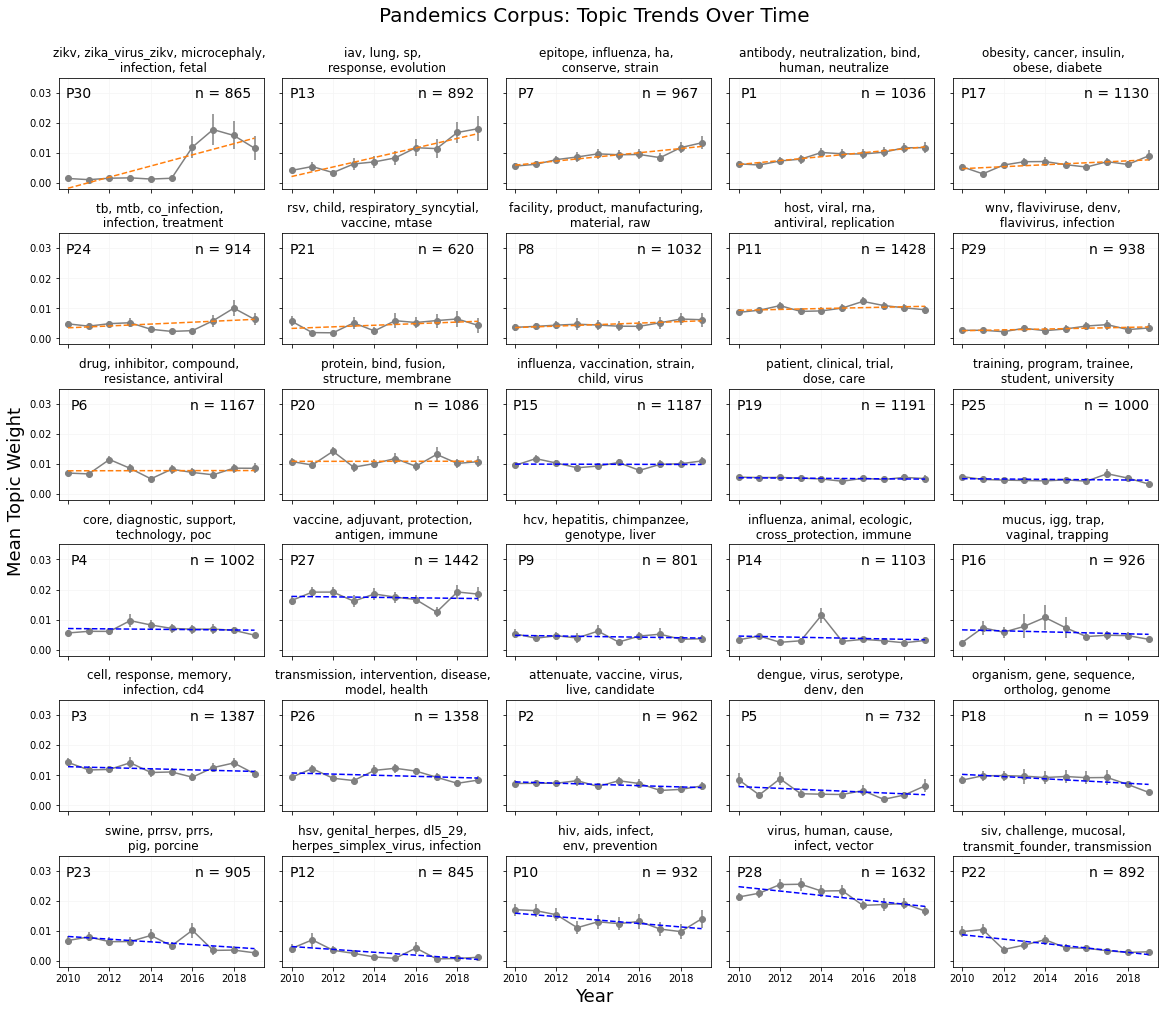

In [48]:
# set up grid
fig, ax = plt.subplots(6, 5, sharex = True, sharey = True, figsize=(16,14))
plt.ylim(bottom = -0.002, top = 0.035)  

# create plot in each grid square
for count,col_idx in enumerate(sorted_slopes):
    
    col = topic_wts_2010_2019.columns[col_idx+1]
    
    # map count to i,j in grid
    i = count // 5
    j = count % 5
    
    linear_fit = stats.linregress(topic_wts_2010_2019["START_YEAR"].values, topic_wts_2010_2019[col].values)
    
    # set color of regression line based on 'hot' or 'cold'
    if(linear_fit.slope > 0): # hot
        reg_line_color = '#ff7f0e'
    else: # cold
        reg_line_color = 'blue'
    
    #ax[i,j].plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019[col], '-o', color = '#1f77b4')

    ax[i,j].errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019[col], 
            yerr = np.array(topic_wts_se_2010_2019[col]), fmt = '-o', color = 'gray', zorder = 10) 
    
    ax[i,j].plot(topic_wts_2010_2019["START_YEAR"], \
        (topic_wts_2010_2019["START_YEAR"]*linear_fit.slope)+linear_fit.intercept, \
        linestyle = 'dashed', color = reg_line_color, zorder = 20)
    
    ax[i,j].grid(color = "whitesmoke")
    
    # add annotations - number of nonzero project topic weights per point
    #for k, txt in enumerate(topic_counts_filt[col]):
    #    ax[i,j].annotate(txt, xy = (topic_wts_2010_2019["START_YEAR"][k+25], topic_wts_2010_2019[col][k+25]), \
    #                    xycoords = 'data', xytext = (1,8), textcoords = "offset points")

    # put legend on two lines for topics 17, 21
    #if count == 16:
    #    ax[i,j].set_title('interagency_agreement_niaid, \n avian_influenza, basic, swine, pathogenic', \
    #                      fontsize = 12)
    #elif count == 27:
    #    ax[i,j].set_title('poultry, transmission, \n avian_influenza_virus, raptor, bird', fontsize = 12)
    #else:
    ax[i,j].set_title(new_leg[col_idx], fontsize = 12)
    
    # add topic number to each plot
    ax[i,j].text(0.10, 0.85, str(L_df['Label'].iloc[col_idx]), horizontalalignment='center', verticalalignment='center', \
                 transform=ax[i,j].transAxes, fontsize = 14)
    
    # add number of documents including topic to each plot - should this be dominant topic only? or some threshold?
    ax[i,j].text(0.80, 0.85, "n = " + str(n_by_topic[col_idx]), horizontalalignment='center', verticalalignment='center', \
                 transform=ax[i,j].transAxes, fontsize = 14)
    
    
fig.suptitle('Pandemics Corpus: Topic Trends Over Time', fontsize = 20)
fig.text(0.5, -0.002, 'Year', ha='center', va='center', fontsize = 18)
fig.text(-0.002, 0.5, 'Mean Topic Weight', ha='center', va='center', rotation='vertical', fontsize = 18)
fig.tight_layout()
fig.subplots_adjust(top=0.91)

plt.savefig("pan_topic_trends.png", dpi = 800, bbox_inches = "tight")
plt.show()

In [49]:
# get legend items for too long titles (topic 2)

new_leg[sorted_slopes[16]-1]
new_leg[sorted_slopes[27]-1]


'influenza, vaccination, strain, \n child, virus'

### Descriptive statistics on corpus

In [50]:
df["START_YEAR"].value_counts()

2009    409
2010    385
2011    366
2008    323
2012    322
2016    255
2014    244
2015    243
2013    210
2018    201
2017    197
2019    175
2007    151
2006     73
2003     52
2005     41
2004     39
2001     23
1999     20
2002     17
2000     11
1997     10
1998      9
1993      8
1983      7
1990      6
1977      5
1991      5
1987      5
1994      5
1981      3
1995      3
1992      3
1996      3
1989      3
1976      3
2020      1
1979      1
1984      1
1980      1
Name: START_YEAR, dtype: int64

In [51]:
df["DEPARTMENT"].value_counts()

HHS     3451
USDA     219
NSF      133
DOD       24
VA         5
NASA       4
EPA        3
Name: DEPARTMENT, dtype: int64

In [52]:
# filter data frame by year and repeat descriptive statistics.  Limit years to those for emerging topic analysis.

filt_df = df.copy()
filt_df["START_YEAR"] = filt_df["START_YEAR"].astype('int')

filt_df = filt_df[filt_df["START_YEAR"] > 2009]
filt_df = filt_df[filt_df["START_YEAR"] < 2020]

In [53]:
year_counts = filt_df["START_YEAR"].value_counts().sort_index()
print(year_counts)

2010    385
2011    366
2012    322
2013    210
2014    244
2015    243
2016    255
2017    197
2018    201
2019    175
Name: START_YEAR, dtype: int64


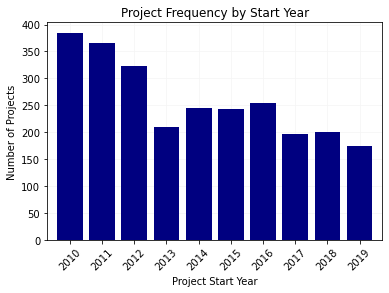

In [55]:
# plot
year = year_counts.index.tolist()
count = year_counts.values

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_axisbelow(True)
plt.grid(True, color = "whitesmoke")
plt.bar(year, count, color='navy')
plt.xticks(year, rotation=45)
plt.xlim(2009.3,2019.7)
#x_ticks = ax.xaxis.get_major_ticks()
#x_ticks[-1].label1.set_visible(False)
plt.xlabel("Project Start Year")
plt.ylabel("Number of Projects")
plt.title("Project Frequency by Start Year");

#plt.savefig("pan_startyr_freq.png", dpi = 800, bbox_inches = "tight")

In [56]:
agency_counts = filt_df["DEPARTMENT"].value_counts()
print(agency_counts)

HHS     2310
USDA     159
NSF       96
DOD       24
EPA        3
VA         3
NASA       3
Name: DEPARTMENT, dtype: int64


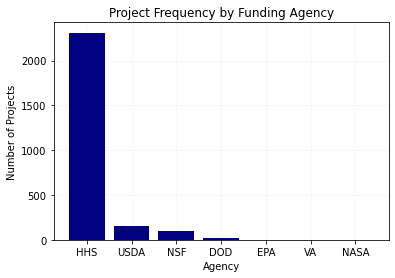

In [57]:
# plot
agency = agency_counts.index.tolist()
count = agency_counts.values

#reload(plt)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_axisbelow(True)
plt.grid(True, color = "whitesmoke")
plt.bar(agency, count, color='navy')
plt.xlabel("Agency")
plt.ylabel("Number of Projects")
plt.title("Project Frequency by Funding Agency");

#plt.savefig("pan_agency_dist.png", dpi = 800, bbox_inches = "tight")

In [58]:
filt_df.pivot_table(index=['DEPARTMENT','START_YEAR'], aggfunc='size')

DEPARTMENT  START_YEAR
DOD         2010            1
            2014            1
            2015            2
            2016            1
            2017            3
            2018           11
            2019            5
EPA         2011            1
            2012            1
            2015            1
HHS         2010          343
            2011          317
            2012          286
            2013          186
            2014          217
            2015          209
            2016          219
            2017          181
            2018          182
            2019          170
NASA        2012            1
            2014            1
            2015            1
NSF         2010           18
            2011           12
            2012           10
            2013            6
            2014            8
            2015           16
            2016           10
            2017           10
            2018            6
USDA        2010 

In [59]:
filt_df.shape

(2598, 33)

## Scratch work 

**try other ways to show topic prevalence, number of projects, project costs**

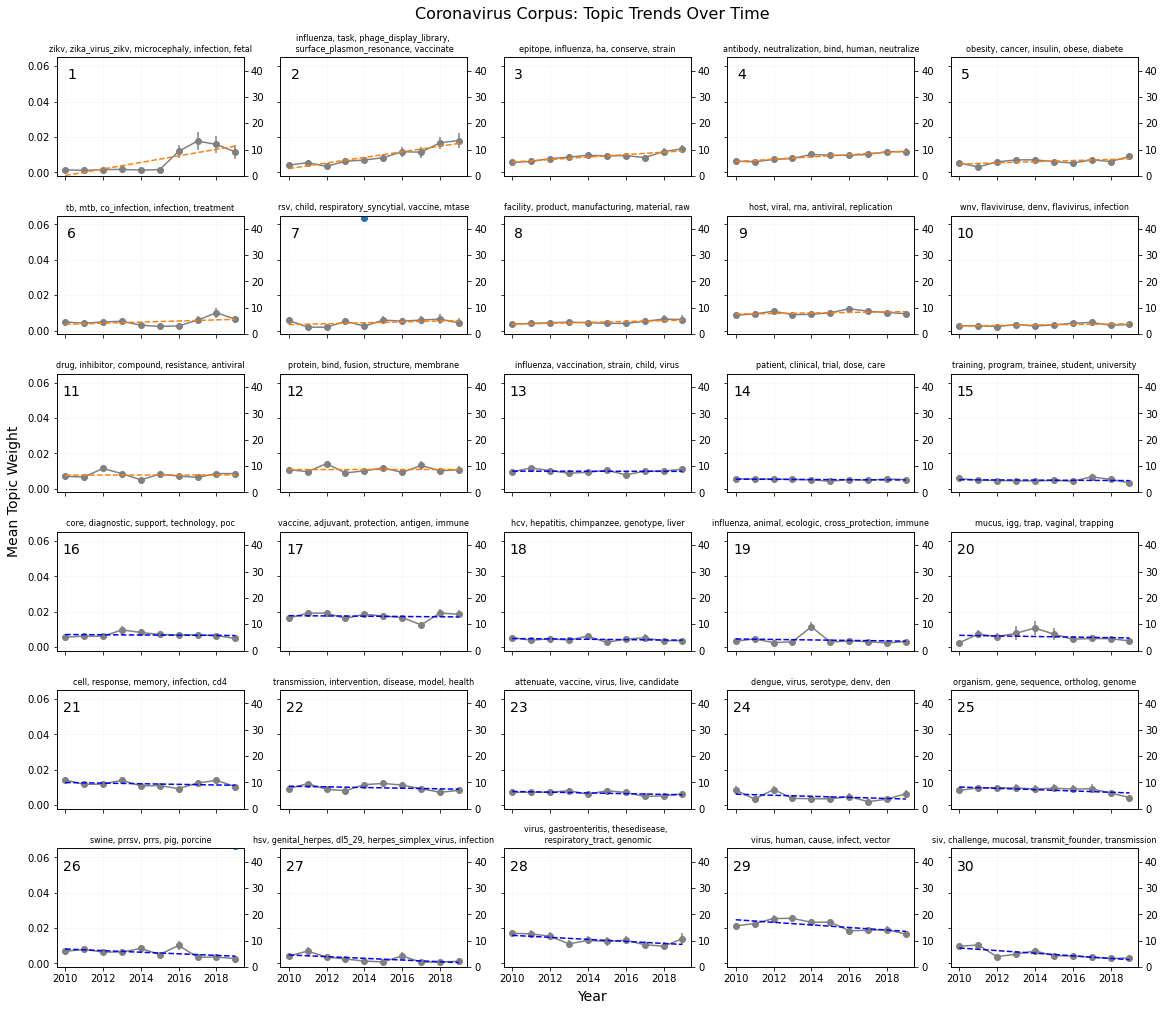

In [61]:
# dual axis approach

# set up grid
fig, ax = plt.subplots(6, 5, sharex = True, sharey = True, figsize=(16,14))
plt.ylim(bottom = -0.002, top = 0.065)

# create plot in each grid square
for count,col_idx in enumerate(sorted_slopes):
    
    col = topic_wts_2010_2019.columns[col_idx]
    
    # map count to i,j in grid
    i = count // 5
    j = count % 5
    
    linear_fit = lm().fit(
        topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019[col].values.reshape(-1,1))
    
    # set color of regression line based on 'hot' or 'cold'
    if(linear_fit.coef_[0][0] > 0): # hot
        reg_line_color = '#ff7f0e'
    else: # cold
        reg_line_color = 'blue'
    
    #ax[i,j].plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019[col], '-o', color = '#1f77b4')

    ax[i,j].errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019[col], 
            yerr = np.array(topic_wts_se_2010_2019[col]), fmt = '-o', color = 'gray', zorder = 10) 
    
    ax[i,j].plot(topic_wts_2010_2019["START_YEAR"], \
        (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_, \
        linestyle = 'dashed', color = reg_line_color, zorder = 20)
    
    ax[i,j].grid(color = "whitesmoke")
    
    # try dual axis
    ax2 = ax[i,j].twinx()
    ax2.plot(topic_wts_2010_2019["START_YEAR"], topic_counts_filt[col], '-o')
    ax2.set_ylim(0,45)
    

    # put legend on two lines for topics 2, 28
    if count == 1:
        ax[i,j].set_title('influenza, task, phage_display_library, \n surface_plasmon_resonance, vaccinate', \
                          fontsize = 8)
    elif count == 27:
        ax[i,j].set_title('virus, gastroenteritis, thesedisease, \n respiratory_tract, genomic', fontsize = 8)
    else:
        ax[i,j].set_title(leg[col_idx-1], fontsize = 8)
    
    # add topic number to each plot
    ax[i,j].text(0.08, 0.85, str(count+1), horizontalalignment='center', verticalalignment='center', \
                 transform=ax[i,j].transAxes, fontsize = 14)
    
    
fig.suptitle('Coronavirus Corpus: Topic Trends Over Time', fontsize = 16)
fig.text(0.5, -0.002, 'Year', ha='center', va='center', fontsize = 14)
fig.text(-0.002, 0.5, 'Mean Topic Weight', ha='center', va='center', rotation='vertical', fontsize = 14)
fig.tight_layout()
fig.subplots_adjust(top=0.93)

#plt.savefig("../figures/coronavirus/topic_trends.png", dpi = 800, bbox_inches = "tight")
plt.show()

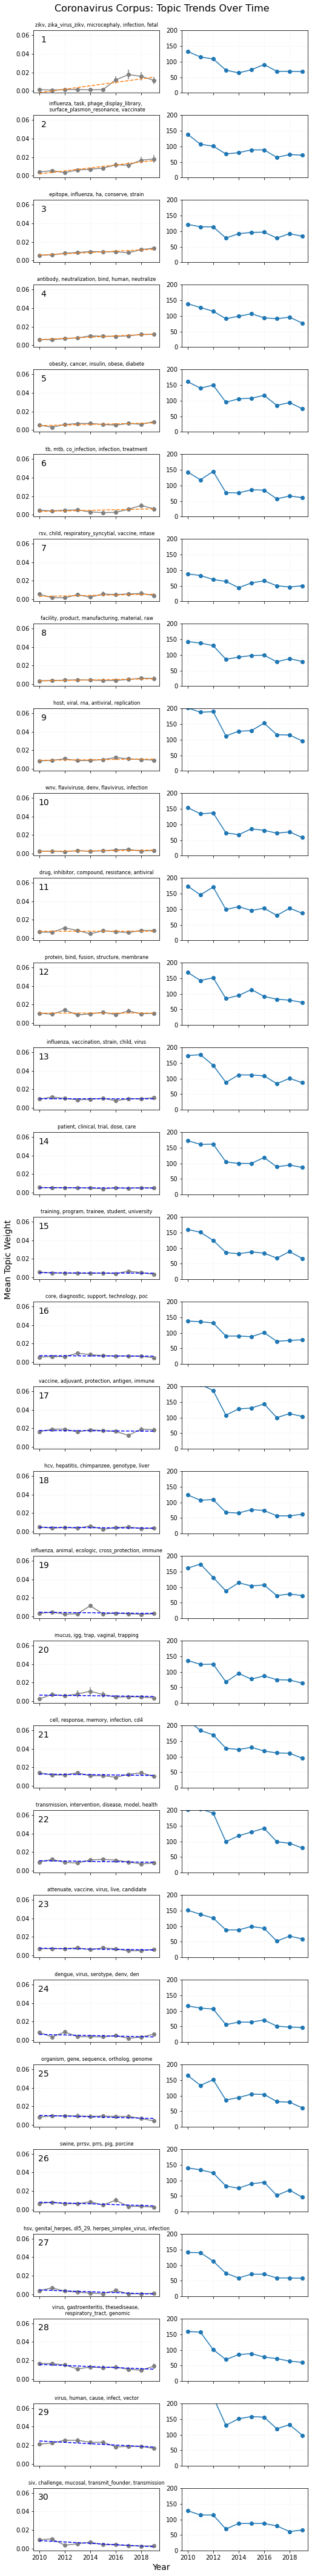

In [64]:
# try with multiple graphs per topic

# set up grid
fig, ax = plt.subplots(30, 2, sharex = True, sharey = 'col', figsize=(7,60))
#plt.ylim(bottom = -0.002, top = 0.065)

# create plots for each row
for count,col_idx in enumerate(sorted_slopes):
    
    col = topic_wts_2010_2019.columns[col_idx]
    
    # 1: mean topic weights plot
    
    linear_fit = lm().fit(
        topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019[col].values.reshape(-1,1))
    
    # set color of regression line based on 'hot' or 'cold'
    if(linear_fit.coef_[0][0] > 0): # hot
        reg_line_color = '#ff7f0e'
    else: # cold
        reg_line_color = 'blue'
    
    #ax[i,j].plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019[col], '-o', color = '#1f77b4')

    ax[count,0].errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019[col], 
            yerr = np.array(topic_wts_se_2010_2019[col]), fmt = '-o', color = 'gray', zorder = 10) 
    
    ax[count,0].plot(topic_wts_2010_2019["START_YEAR"], \
        (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_, \
        linestyle = 'dashed', color = reg_line_color, zorder = 20)
    
    ax[count,0].grid(color = "whitesmoke")
    
    # put title on two lines for topics 2, 28
    if count == 1:
        ax[count,0].set_title('influenza, task, phage_display_library, \n surface_plasmon_resonance, vaccinate', \
                          fontsize = 8)
    elif count == 27:
        ax[count,0].set_title('virus, gastroenteritis, thesedisease, \n respiratory_tract, genomic', fontsize = 8)
    else:
        ax[count,0].set_title(leg[col_idx-1], fontsize = 8)
    
    # add topic number to each plot
    ax[count,0].text(0.08, 0.85, str(count+1), horizontalalignment='center', verticalalignment='center', \
                 transform=ax[count,0].transAxes, fontsize = 14)
    
    ax[count,0].set_ylim(-0.002,0.065)
    
    # 2. Number of projects plot

    ax[count,1].plot(topic_wts_2010_2019["START_YEAR"], topic_counts_filt[col], '-o')
    ax[count,1].set_ylim(0,200)
    ax[count,1].grid(color = "whitesmoke")
    
    
fig.suptitle('Coronavirus Corpus: Topic Trends Over Time', fontsize = 16)
fig.text(0.5, 0, 'Year', ha='center', va='center', fontsize = 14)
fig.text(-0.002, 0.5, 'Mean Topic Weight', ha='center', va='center', rotation='vertical', fontsize = 14)
fig.tight_layout()
fig.subplots_adjust(top=0.97)

#plt.savefig("../figures/coronavirus/topic_trends.png", dpi = 800, bbox_inches = "tight")
plt.show()